In [21]:
import os

image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2

In [23]:
dataset_path = r'D:\xray-chest\yolov5-master\dataset'

In [24]:
samples = 25

In [25]:
covid_dataset_path = "D:/xray-chest/yolov5-master/covid"

In [26]:
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [27]:
pneumonia_dataset_path = r'D:\xray-chest\yolov5-master\chest_xray'

In [28]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [29]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [30]:
normal_images = list(list_images(f"{dataset_path}/normal"))
covid_images = list(list_images(f"{dataset_path}/covid"))

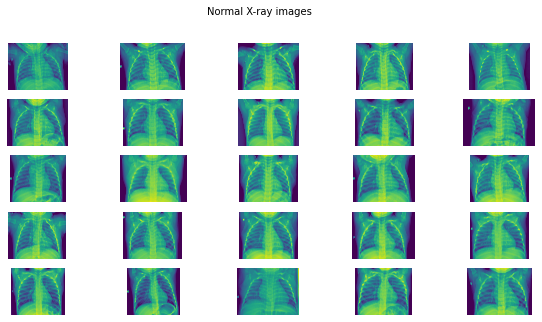

In [31]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

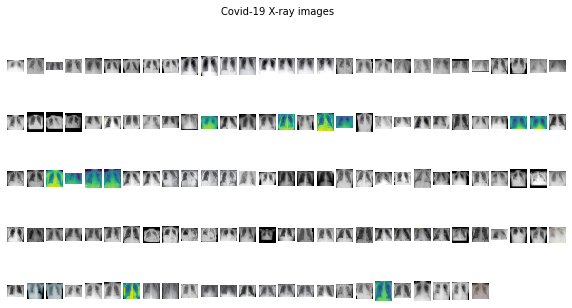

In [32]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

In [33]:
INIT_LR = 1e-3
EPOCHS = 30
BS = 8

In [34]:
print("[INFO] loading images...")
imagePaths = list(list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [35]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [38]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 30s 0us/step


In [39]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/30


D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 11s 332ms/step - loss: 0.5812 - accuracy: 0.7669 - val_loss: 0.4460 - val_accuracy: 0.8529
Epoch 2/30
16/16 [==============================] - 2s 121ms/step - loss: 0.4818 - accuracy: 0.8446 - val_loss: 0.4219 - val_accuracy: 0.8529
Epoch 3/30
16/16 [==============================] - 2s 121ms/step - loss: 0.4984 - accuracy: 0.7794 - val_loss: 0.4519 - val_accuracy: 0.8529
Epoch 4/30
16/16 [==============================] - 2s 119ms/step - loss: 0.5796 - accuracy: 0.8171 - val_loss: 0.4250 - val_accuracy: 0.8529
Epoch 5/30
16/16 [==============================] - 2s 118ms/step - loss: 0.4671 - accuracy: 0.8202 - val_loss: 0.4001 - val_accuracy: 0.8529
Epoch 6/30
16/16 [==============================] - 2s 121ms/step - loss: 0.5602 - accuracy: 0.7940 - val_loss: 0.3956 - val_accuracy: 0.8529
Epoch 7/30
16/16 [==============================] - 2s 122ms/step - loss: 0.4219 - accuracy: 0.8394 - val_loss: 0.3990 - val_accuracy: 0.8529
Epoch 8/30
16/16

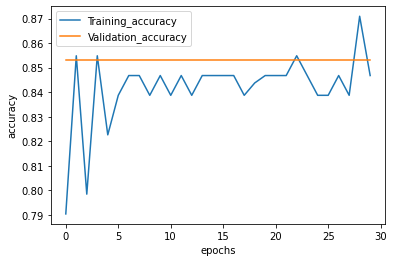

In [40]:
accs = H.history['accuracy']
val_accs = H.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

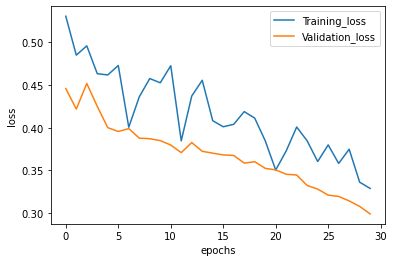

In [41]:
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.plot(range(len(accs)),loss, label = 'Training_loss')
plt.plot(range(len(accs)),val_loss, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

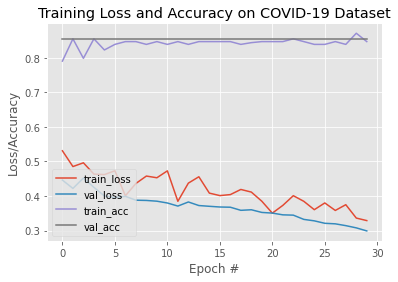

In [42]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [43]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.85      1.00      0.92        29
      normal       0.00      0.00      0.00         5

    accuracy                           0.85        34
   macro avg       0.43      0.50      0.46        34
weighted avg       0.73      0.85      0.79        34



D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[29  0]
 [ 5  0]]
acc: 0.8529
sensitivity: 1.0000
specificity: 0.0000
